# 🏛️ From Ivory Tower to Wall Street: A Brief (and Slightly Funny) History of Quants

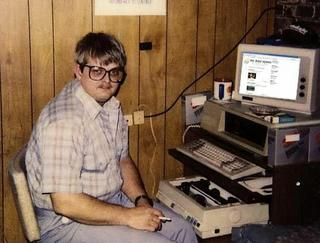

Once upon a time, in the sacred halls of academia, math nerds roamed freely—armed with chalk, Gaussian distributions, and no plans to leave the university basement. But somewhere around the 1970s, a brave few decided to leave their natural habitat and try something *truly dangerous*: **Wall Street**.

Thus began the era of the **Quant**—short for "quantitative analyst," long for "that person who models financial markets using math that gives everyone else headaches."

It all kicked off with people like **Fischer Black, Myron Scholes**, and **Robert Merton**, who realized you could use stochastic calculus (a fancy way of saying “random math with squiggles”) to price options. This was revolutionary—suddenly, financial assets weren’t just magic paper, they were equations. The **Black-Scholes model** was born, and with it, the concept of quantitative finance took off like a Tesla stock after a stock split.

By the 1980s and 90s, investment banks started hoarding physicists, mathematicians, and computer scientists like Pokémon cards. These "quants" built models, crunched numbers, and slowly began replacing cigar-smoking traders with spreadsheets, algorithms, and code. Some even say Excel was the original quant tool (and they're not wrong, which is terrifying).

Fast-forward to today, and quants are the brains behind algorithmic trading, risk models, and that one hedge fund that made a billion dollars off a 0.3% anomaly in soybean futures.

In this project, I’m stepping into that world—not to become the next Renaissance Technologies (yet), but to understand and implement the core techniques that underpin modern quantitative analysis.

We’ll dive into:
- Simulating stock prices with **Geometric Brownian Motion**
- Exploring randomness through **Stochastic Processes**
- Modeling transitions with **Markov Chains**
- And building real-world **Forecasting models** to predict where prices *might* go (even though they probably won’t, because markets are mean like that)

Let’s get quantitative.


We will be working with some data related to stocks. The data was obtained from Yahoo Finance and tabulated to mimic the synthetic stock data table provided below. The reason we did not use the synthetic stock data for these analyses was the significant gap in time that the stock prices were reported for. Even though it is meant to be 'fake', it does not provide us with enough data points to create accurate models.

The reference dataset was taken from Kaggle and can be found with the following link: https://www.kaggle.com/datasets/samayashar/stock-market-simulation-dataset

Note that the source data from Yahoo Finance is quite long and may take a significant amount of time to run. We will manipulate the new dataset only to include the most recent years worth of data, and will perform our analyses related to that new dataset.

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import yfinance as yf

conn = sqlite3.connect('synthetic_stock_data.csv')
cursor = conn.cursor()

ref_table = pd.read_csv('synthetic_stock_data.csv')
display(ref_table.head())

,Date,Company,Sector,Open,High,Low,Close,Volume,Market_Cap,PE_Ratio,Dividend_Yield,Volatility,Sentiment_Score,Trend
0,1/1/2022,Uber,Technology,100.000000,101.036120,97.477809,100.000000,171958,5.156585e+11,24.253218,0.163090,0.047484,0.939232,Bearish
1,1/2/2022,Tesla,Automotive,100.071106,102.037960,97.152675,100.071106,196867,9.755658e+11,18.602848,0.288515,0.022472,0.469417,Bearish
2,1/3/2022,Panasonic,Finance,99.857828,101.517497,98.108097,99.857828,181932,4.595300e+11,10.728933,2.221827,0.019991,0.399193,Bullish
3,1/4/2022,Tencent,Automotive,98.851663,101.303783,96.998218,98.851663,153694,5.577481e+11,14.582696,1.377740,0.036166,0.705853,Stable
4,1/5/2022,Wells Fargo,Automotive,98.391118,99.990486,96.230707,98.391118,169879,8.607714e+11,37.491114,3.110198,0.034770,-0.768354,Stable



In the reference table named 'ref_table' above, there are several columns relating to different stock details that either characterize the company or display metrics that can be used to interpret a company's performance and valuation.


## 📈 Lets import some data! 

After sifting through the synthetic reference data above, we notice that there are four companies related to Aerospace and Defense. Using the ticker symbols for these four companies and General Dynamics (to complete the big 5), lets import the respective data columns to new DataFrames.

Using yf.download() to obtain historical data, we are restricted to only a handful of metrics. Luckily, these are the ones we will need!

In [2]:
ticker = "BA","GD","LMT", "NOC", "RTX"
defense_df = yf.download(ticker, start = "2022-01-01", end = "2024-01-01")
display(defense_df)

#Red box expected

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  5 of 5 completed


Price            Close                                                 \
Ticker              BA          GD         LMT         NOC        RTX   
Date                                                                    
2022-01-03  207.860001  192.210602  325.200989  366.019745  80.498505   
2022-01-04  213.630005  196.463196  332.203156  376.899811  83.321556   
2022-01-05  213.070007  194.851089  328.669952  375.001068  82.905037   
2022-01-06  211.339996  196.175980  328.541565  377.165649  83.358566   
2022-01-07  215.500000  196.500259  330.505402  380.156250  83.710312   
...                ...         ...         ...         ...        ...   
2023-12-22  260.440002  246.383820  433.584534  453.437195  80.911110   
2023-12-26  262.790009  248.429703  435.480499  454.778534  81.708260   
2023-12-27  262.100006  249.612671  434.310089  454.504364  81.824905   
2023-12-28  260.350006  250.301147  436.496277  455.933807  81.824905   
2023-12-29  260.660004  251.784683  438.440613  458.342316  81.795753   

Price             High                                                 ...  \
Ticker              BA          GD         LMT         NOC        RTX  ...   
Date                                                                   ...   
2022-01-03  210.550003  194.146972  327.247500  368.431213  80.655853  ...   
2022-01-04  214.559998  196.843062  333.625628  377.716304  83.367838  ...   
2022-01-05  218.929993  198.668243  334.047740  379.349308  84.719191  ...   
2022-01-06  216.000000  198.306906  331.514949  379.596095  84.163831  ...   
2022-01-07  218.320007  198.149419  333.120863  380.849289  84.571110  ...   
...                ...         ...         ...         ...        ...  ...   
2023-12-22  262.839996  247.508583  436.989587  455.689046  81.523555  ...   
2023-12-26  263.760010  249.011489  436.699367  456.012173  81.951294  ...   
2023-12-27  264.660004  249.903579  436.293140  456.100255  82.116550  ...   
2023-12-28  262.100006  250.931403  437.076662  457.627611  82.252649  ...   
2023-12-29  262.220001  251.988298  438.692133  459.115760  82.058235  ...   

Price             Open                                                 \
Ticker              BA          GD         LMT         NOC        RTX   
Date                                                                    
2022-01-03  204.000000  193.637397  325.494664  367.367897  79.674731   
2022-01-04  211.300003  193.702246  326.274733  367.928057  81.331544   
2022-01-05  216.639999  197.130273  333.130027  371.250980  83.488156   
2022-01-06  214.639999  196.907904  330.376993  377.440982  83.673270   
2022-01-07  212.979996  196.944987  329.532599  378.162517  83.543706   
...                ...         ...         ...         ...        ...   
2023-12-22  261.829987  245.675977  435.306411  451.792363  79.802865   
2023-12-26  259.799988  246.325601  433.516785  452.879134  80.833333   
2023-12-27  262.630005  247.624935  433.903790  453.211983  81.562431   
2023-12-28  261.529999  250.136297  434.310062  453.701527  81.824905   
2023-12-29  260.670013  250.669581  437.241111  456.452686  81.863803   

Price         Volume                                      
Ticker            BA       GD      LMT      NOC      RTX  
Date                                                      
2022-01-03   9060200   721500  1205700   662100  5169200  
2022-01-04  11414600  1129400  1361100   740500  6044200  
2022-01-05  11564700   876500  1682200  1072500  6833600  
2022-01-06   7142200   864100  1368800   764300  5559000  
2022-01-07   9526400  1408500  1634600   908600  4835300  
...              ...      ...      ...      ...      ...  
2023-12-22   4430500   650600   623600   362300  9768500  
2023-12-26   3938600   637800   516900   420000  4442600  
2023-12-27   3484900   750900   699900   378400  5440600  
2023-12-28   5096400   569700   741800   387700  4622700  
2023-12-29   3681900   812300   832400   403400  4624200  

[501 rows x 25 columns]

## 🛁 Lets clean that table up!

What we will want to do first is remove some unneeded information for the analyses going forward. The only data we will need going forward is the Date, Company, Open, Close, Market_Cap, Volatility, and Sentiment Score. Notice that the Sector and Trend columns do not necessarily correlate, which explains why we will be removing them. For fun we will add the Trend Column back in, but with the correct values this time.

In [3]:
# Reshape the DataFrame
reshaped_data = []
for date, row in defense_df.iterrows():
    for company in ticker:
        row_data = {"Date": date, "Ticker": company}
        for metric in ["Open", "High", "Low", "Close", "Volume"]:
            row_data[metric] = row[(metric, company)]
        reshaped_data.append(row_data)

clean_data = pd.DataFrame(reshaped_data)
clean_data = clean_data.sort_values(by=['Ticker','Date']).reset_index(drop=True) 
clean_data = clean_data.reindex(columns=['Date','Ticker','Open','Close','Volume'])
clean_data['Date'] = pd.to_datetime(clean_data['Date'])

display(clean_data.head())

,Date,Ticker,Open,Close,Volume
0,2022-01-03,BA,204.000000,207.860001,9060200.0
1,2022-01-04,BA,211.300003,213.630005,11414600.0
2,2022-01-05,BA,216.639999,213.070007,11564700.0
3,2022-01-06,BA,214.639999,211.339996,7142200.0
4,2022-01-07,BA,212.979996,215.500000,9526400.0


Notice the way that we redetermined the trends using the values provided in the sentiment score column. Here's more info:

- Sentiment analysis, a process that analyzes text and speech data to determine the sentiment expressed, assigns a score to each piece of data, ranging from -1 (highest negative) to +1 (highest positive), with 0 indicating neutral sentiment. 

Also be aware that although these data points are over a significant period of time, we will be using the 'Close' stock prices as if they were reported on consecutive days (in reality, skipping weekends/days market closed).

Just to give you an idea of what these all look like when compared to one another, here is a plot showing the Stock Price at Day Close over time for the five Defense companies included in this list. All though the data points for each company start and end on different days, we are still able to show the basic trend of the data.

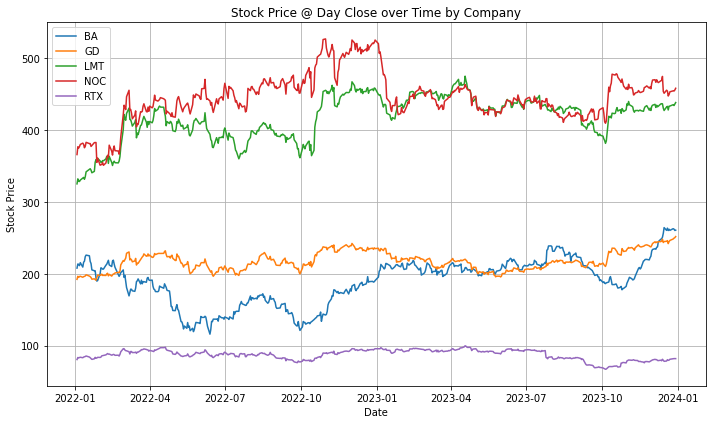

In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Create new dataframe with only defense companies (Boeing, Lockheed Martin, Northrop Grumman, Raytheon, SpaceX)
defense_df = clean_data[clean_data['Ticker'].isin(['BA','GD', 'LMT', 'NOC', 'RTX'])]

# Set up the plot
plt.figure(figsize=(10, 6))

# Group by 'name' and plot each group's values
for name, group in defense_df.groupby('Ticker'):
    plt.plot(group['Date'], group['Close'], label=name)

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price @ Day Close over Time by Company')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 🪃 Geometric Brownian Motion Simulation 🪃

What is Geometric Brownian Motion (GBM) Simulation? Glad you asked!

Geometric Brownian Motion (GBM) is a popular stochastic process used to model stock prices and other financial assets over time. It's widely used in quantitative finance due to its ability to simulate realistic price paths that capture both trend (drift) and randomness (volatility).

GBM models the evolution of a price 𝑆(𝑡) using a stochastic differential equation (SDE):

𝑑𝑆(𝑡) = 𝜇𝑆(𝑡)𝑑𝑡 + 𝜎𝑆(𝑡)𝑑𝑊(𝑡)

Where:

- 𝑆(𝑡): Asset price at time 𝑡
- 𝜇: Drift term (expected return)
- 𝜎: Volatility term (standard deviation of returns)
- 𝑊(𝑡): Standard Brownian motion (a.k.a. Wiener process)

This means the percentage change in price has a deterministic component 𝜇 and a random component scaled by 𝜎.

After applying Itô’s Lemma to leverage logarithmic transformation we are left with the following analytical function.

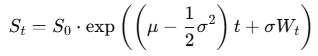


In order to perform GBM, we must first estimate the historical drift (mean log return) and volatility (std.dev) for the company. We will perform this for only one company, but you could replicate the process on all if need be. Since I currently work for Lockheed Martin and am biased, lets use them!

To be more accurate, for this analysis only, we will pull real ticker symbol data from Yahoo finance. The following steps will create Lockheed's stock data in a new DataFrame using the first and perform statistical analysis on it to obtain the required values necessary for performing GBM. 

Use 'lmco_df' shown below for the following analyses.

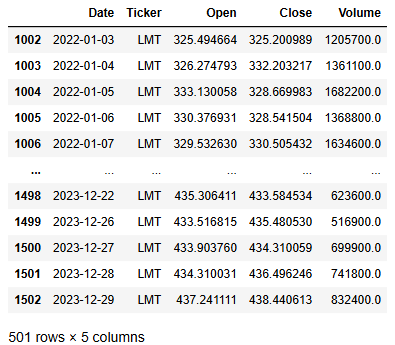


For an added visual, here is a line plot of Lockheed Martin's stock price over time along with a bar chart displaying the trading volume over time. This is a useful display for investors and traders who intend to analyze activity that may cause move in the markets. The code to create this chart is hidden for brevity.


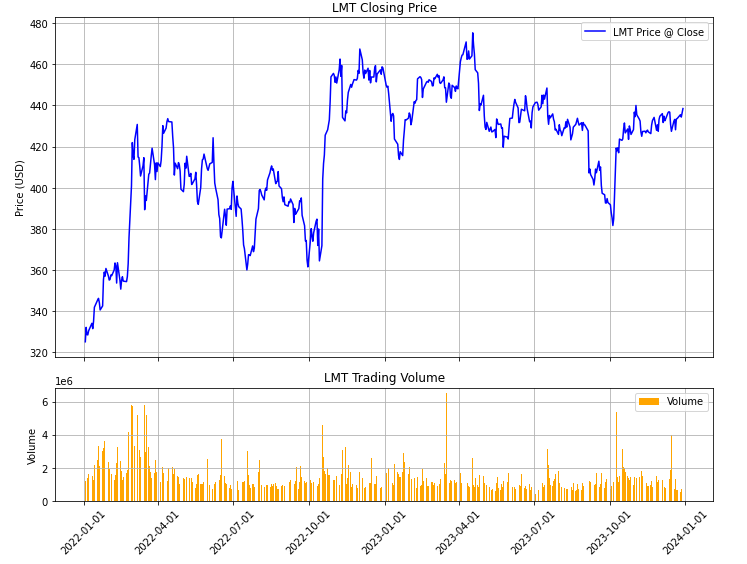


In [5]:
lmco_df = clean_data[clean_data['Ticker'].isin(['LMT'])]

def plot_price_and_volume(df, ticker):
    """
    Plots the closing price as a line chart and volume as a bar chart from an existing DataFrame.

    Args:
        df (pandas.DataFrame): DataFrame with 'Date', 'Close', and 'Volume' columns.
        ticker (str): The stock ticker symbol (for title).
    """

    try:
        if df is None or df.empty:
            print(f"Empty or invalid DataFrame.")
            return

        if 'Date' not in df.columns or 'Close' not in df.columns or 'Volume' not in df.columns:
            print("DataFrame must contain 'Date', 'Close', and 'Volume' columns.")
            return

        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=(10, 8))

        # Convert 'Date' to datetime if it's not already.
        if not pd.api.types.is_datetime64_any_dtype(df['Date']):
            df['Date'] = pd.to_datetime(df['Date'])
        df = df.set_index('Date')

        # Line plot for closing price
        ax1.plot(df['Close'], label=f'{ticker} Price @ Close', color='blue')
        ax1.set_title(f'{ticker} Closing Price')
        ax1.set_ylabel('Price (USD)')
        ax1.legend()
        ax1.grid(True)
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

        # Bar chart for trading volume
        if not df['Volume'].isnull().all() and not (df['Volume'] == 0).all():
            ax2.bar(df.index, df['Volume'], label='Volume', color='orange')
            ax2.set_title(f'{ticker} Trading Volume')
            ax2.set_ylabel('Volume')
            ax2.legend()
            ax2.grid(True)
            ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
            plt.xticks(rotation=45)
        else:
            print(f"No volume data for {ticker} in the provided DataFrame.")

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"An error occurred: {e}")
        
#display(plot_price_and_volume(lmco_df,"LMT"))

First we must compute the log returns and estimate parameters.

In [6]:
# The log returns is the natural log of the stock price divided by the previous stock price. This denotes change
log_returns = np.log(lmco_df['Close']/(lmco_df['Close'].shift(1))).dropna()

# The drift or 'Mu' is the mean of the log returns multipled by the number of trading days in a fiscal year
mu = log_returns.mean() * 252 

# Calculate the standard deviation of the log_returns multiplied by the sqrt of trading periods to estimate 
# annualized volatility
sigma = log_returns.std() * np.sqrt(252)

Now we can simulate and plot the GBM Paths to run what is called a Monte Carlo Simulation.

- Note: The term "Monte Carlo simulation" refers to any method that uses random sampling to estimate mathematical results—especially when:
    - The system is too complex for an exact solution
    - You want to understand distributions, not just single outcomes
    
So, in this case we are using randomized GBM paths in a Monte Carlo Simulation to simulate future stock prices.

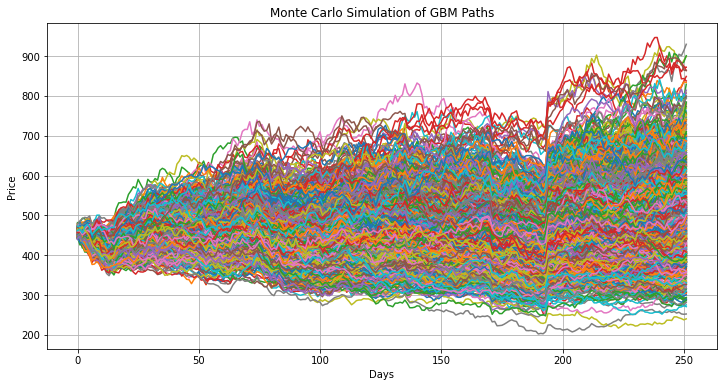

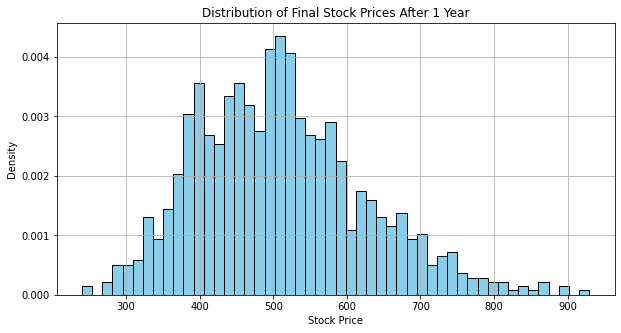

In [7]:
# Known Parameters (run for 1 year(2024-2025))
T = 1  # years
N = 252  # time steps
dt = T / N
S0 = lmco_df['Close'][-252:]  # last actual price

# This specifies the # of paths we want to create. The more you compute, the more accurately you can find likely outcomes
simulations = 1000

# Run the simulation
np.random.seed(42)
paths = np.zeros((N, simulations))
for j in range(simulations):                   # to plot all do range(simulations), we use 10 to not crowd the plot
    W = np.random.standard_normal(size=N)
    W = np.cumsum(W) * np.sqrt(dt)  # cumulative Brownian motion
    X = (mu - 0.5 * sigma**2) * np.linspace(0, T, N) + sigma * W
    paths[:, j] = S0 * np.exp(X)

# Create Plot including all simulation runs
plt.figure(figsize=(12,6))
plt.plot(paths)
plt.title("Monte Carlo Simulation of GBM Paths")
plt.xlabel("Days")
plt.ylabel("Price")
plt.grid(True)
plt.show()


# Create Histogram of stock prices at the end of simulation (start of 2025)
final_prices = paths[-1, :]  # prices at T=1 year

plt.figure(figsize=(10, 5))
plt.hist(final_prices, bins=50, color='skyblue', edgecolor='black', density=True)
plt.title("Distribution of Final Stock Prices After 1 Year")
plt.xlabel("Stock Price")
plt.ylabel("Density")
plt.grid(True)
plt.show()

The Histogram above shows that the data, or outcome of multiple GBM simulation paths, follows a lognormal distribution which is always skewed to the right (positive direction). The degree of skewness does depend on the variance of the underlying normal distribution (not all the same). So the big final question is why did we do this. Well, lets use some statistical calculates to compare our estimated values to the true stock price at the beginning of 2025.

In [8]:
# Calculate the mean of the final prices
average_final_price = np.mean(final_prices)
print(f"The average price of LMT Stock at the beginning of 2025 is expected to be ${average_final_price:.2f}")

# Calculate the standard deviation of the final prices
std_dev = np.std(final_prices)

# Calculate the 95% confidence interval 
lower = np.percentile(final_prices, 2.5)
upper = np.percentile(final_prices, 97.5)

print(f"95% confidence interval: ${lower:.2f} to ${upper:.2f}")

# Calculate Value at Risk (VaR)
var_5 = np.percentile(final_prices, 5)
print(f"In the worst 5% of cases, we'd expect to end up with ${var_5:.2f} or less")



The average price of LMT Stock at the beginning of 2025 is expected to be $509.42
95% confidence interval: $317.51 to $757.37
In the worst 5% of cases, we'd expect to end up with $343.30 or less


### 🧮 Statistical Values and Comparison to Actual

Given the statics above, what does this mean? Well, the actual stock price on December 31st, 2024, was \\$485.94, and the estimated value based on our Monte Carlo Simulation was $587.30. So, if you had invested in Lockheed Martin Stock at the beginning of 2024 with the expectation of a 28.74% return on investment, you would have fallen short by about 22.24%.

However, if it was the day you invested and the future was unknown, the 95% confidence interval would help an investor to identify the upside potential vs the downside potential. In Lockheed Martins case, the stock did make major moves in the upward direction throughout the year, which may have been a good opportunity to take profits and manage future risk. 

Additionally, the calculation of a 5% value at risk allows us to estimate the stock price in the worst 5% of cases. This is helpful to know when investing and/or trading options.


### 🏴󠁭󠁣󠁭󠁣󠁿 Conclusions for Geometric Brownian Motion and Monte Carlo Simulation

While **Monte Carlo simulations** using **Geometric Brownian Motion (GBM)** provide useful insights into potential stock price paths, the method is far from perfect. These models rely on randomness to simulate volatility, but they don’t incorporate real-world macroeconomic factors, sector-specific trends, or fundamental company data.

For example, if a company launches a revolutionary new product, restructures its operations, or faces unexpected regulatory hurdles, GBM won’t capture that. The model also assumes constant volatility and drift over time—conditions that rarely hold true in financial markets. Additionally, GBM assumes normally distributed log returns, which underestimates the probability of extreme events (fat tails).

Forecasts generated from this process should be viewed as **probabilistic estimates, not deterministic predictions**. Adjustments can be made as new information becomes available, but these limitations highlight the importance of supplementing statistical models with real-world insights and judgment.

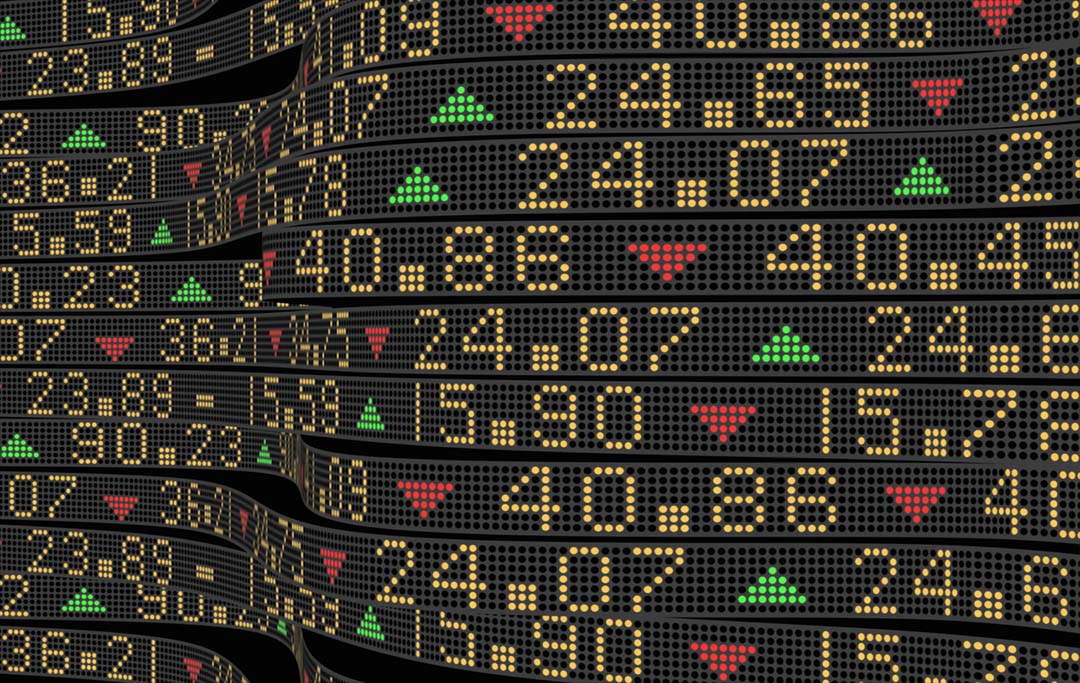

## ♠️ Black-Scholes Model ♠️

The **Black-Scholes** model gives a "fair value" of an option by assuming that the underlying stock follows a Geometric Brownian Motion—which is exactly what we've been simulating! This model is generally used for **European-style options** on non-dividend paying stocks. For those who are are new to finance and even those who are well-versed in the area, the difference between European-style options and American-style options is that the former can only be exercised on their expiration date, whereas, the latter can be exercised at any time before or on expiration (making them less predictable).

A good way to consider this may be the way a Quant would think about it in their heads...

     “Given the current stock price, time left, volatility, and interest rates, what should someone rationally pay for the 
     right to buy or sell this stock in the future?”

The price 𝐶 of a European call option is given by:

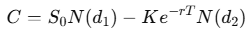

And the price P of a European put option is given by:



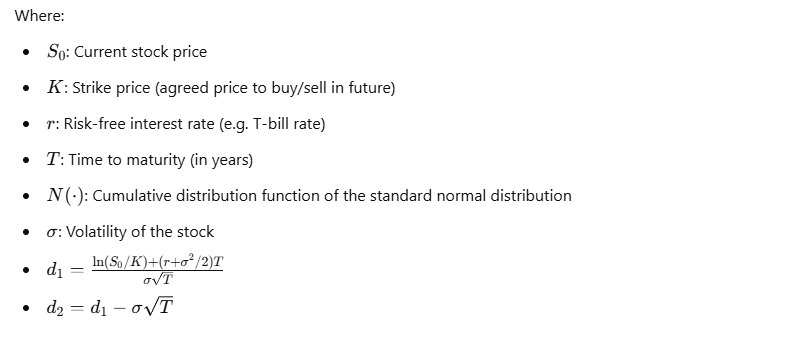

First, we will write a function that given inputs of the Current Stock Price, Strike Price, Risk-free interest rate, Time to maturity (years), and the stock Volatility, calculates the d1 and d2 values and returns the price of the call option. We will follow that up with the put option as well. It is important to note that the d-values help us to determine how "deep in the money" that option is. A call option is 'in the money' when the stock's current price is higher than the option's strike price. For a put option, it's 'in the money' when the stock's current price is lower than the strike price. Essentially, 'in the money' means the option has immediate intrinsic value because it could be exercised for a profit right now. However, these options are typically more expensive, which can increase the potential loss if the stock price moves against you.

The **Black-Scholes model** can be applied to an entire dataset and used to display how option prices evolve over time, but since we do not have the volatility and interest-rate values for each data point, it would be a highly inaccurate output. It would not be that difficult to estimate and/or obtain, but it is not necessary in expressing the fundamental understanding of this model. Thus, we only calculate it for the first day of 2025 at the end of our **Monte Carlo Simulation** result.

In [9]:
from scipy.stats import norm

def black_scholes_call(S0, K, T, r, sigma):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    call_price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price


In [10]:
# Call both functions
S0 = 485.94  # actual stock price at start of 2025
K = 480  # in the money call
T = 0.5  # years
r = 0.0456  # 4.56% interest rate (accurate to 2025-01-01)
sigma = 0.39  # 39% volatility (accurate to 2025-01-01)

bs_call_price = black_scholes_call(S0, K, T, r, sigma)


In [11]:
def black_scholes_put(S0, K, T, r, sigma):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    return max(0.0, put_price)

In [12]:
# Call both functions
S0 = 485.94  # actual stock price at start of 2025
K = 490  # in the money put
T = 0.5  # years
r = 0.0456  # 4.56% interest rate (accurate to 2025-01-01)
sigma = 0.39  # 39% volatility (accurate to 2025-01-01)

bs_put_price = black_scholes_put(S0, K, T, r, sigma)


In [13]:
print(f"The call option would be priced at ${bs_call_price:.2f} per share.")
print(f"The put option would be priced at ${bs_put_price:.2f} per share.")

The call option would be priced at $61.17 per share.
The put option would be priced at $49.49 per share.


### 🏁 Conclusion

The Black-Scholes model is a **foundational tool in quantitative finance** and remains widely used for pricing European options. Its value lies in its analytical simplicity, speed, and the ability to provide closed-form solutions based on a small set of inputs: the current stock price, strike price, time to expiration, volatility, and the risk-free rate. For traders, analysts, and portfolio managers, it serves as a benchmark model to quickly assess the fair value of an option under ideal market conditions.

However, like most models, **Black-Scholes comes with important limitations**. It assumes constant volatility and interest rates, continuous trading, no transaction costs, and normally distributed returns—all of which are simplifications of real-world markets. One of its most significant weaknesses is the assumption that price movements follow a geometric Brownian motion, which fails to capture sudden jumps, fat tails, or skewness in asset returns. Additionally, the model assumes European-style options (which can only be exercised at expiration), limiting its direct applicability to American options or more complex derivatives.

**To improve upon Black-Scholes, practitioners often:**

    1. Use stochastic volatility models (like Heston) to better capture the dynamics of changing volatility.
    2. Incorporate jump-diffusion processes (like Merton's model) to account for sudden price shocks.
    3. Calibrate models using implied volatility surfaces rather than assuming a single, constant volatility.

Despite its flaws, the Black-Scholes model remains an essential stepping stone in financial modeling. It teaches core mathematical finance concepts, provides a baseline for more advanced models, and can still produce reliable results in many practical scenarios—especially when volatility is stable and the option is near-the-money.

## 🔗 Markov Chain Analysis 🔗



Who is Markov and what chain is he analyzing? What's the point anyway?



The image above may make sense to some immediately, but what about it makes sense? Maybe, that the arrows seem to have no real path, and that they mimic an almost random type of decision matrix. If you considered that as a possibility, you're well on your way to becoming a Quant.

Why is this important for Quant's or other Market Analysts? Why would they care whether its rainy or sunny when all they do is stare at stock charts all day anyway.

Valid question. You see, this has absolutely nothing to do with the weather, but much to do with the transitition from one state to another. 

A **Markov Chain** is a type of stochastic process that undergoes transitions from one state to another in a state space.

The key property is such that the future state ONLY depends on the current state, and not the sequence of events leading up to it. Hence, a memoryless process.

As opposed to rainy or sunny, stocks returns can be discretized as the following finite states:

    - Up (U)
    - Down (D)
    - Stable (S)
    
The transition from state to state (i to j) is defined by the **transition probability, Pij**, and is often placed into a **transition matrix, P**.

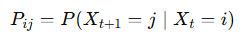
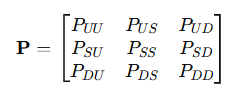

In this part of the lesson we will perform a handful of operations to model stock prices.

    1. Map daily returns to discrete states
    2. Count the transitions from state to state
    3. Normalize counts to get probabilities
    
By doing those three things we can predict future states, simulate movement patters, and compare behavior across our five defense companies.

The following function get_transition_matrix is created to take in a list of stock prices and paired with epsilon, 

In [14]:
def get_transition_matrix(prices, epsilon=0.002):
    """
    Generate a 3x3 transition matrix from a Series of stock prices.

    Parameters:
    - prices (pd.Series): Daily closing prices
    - epsilon (float): Threshold for 'Stable' state (default = 0.2% return)

    Returns:
    - transition_matrix (pd.DataFrame): 3x3 matrix with probabilities
    """
    # Step 1: Compute log returns
    returns = np.log(prices / prices.shift(1)).dropna()

    # Step 2: Discretize into states
    states = []
    for r in returns:
        if r > epsilon:
            states.append('U')  # Up
        elif r < -epsilon:
            states.append('D')  # Down
        else:
            states.append('S')  # Stable

    # Step 3: Count transitions
    transitions = {'U': {'U': 0, 'S': 0, 'D': 0},
                   'S': {'U': 0, 'S': 0, 'D': 0},
                   'D': {'U': 0, 'S': 0, 'D': 0}}

    for (prev, curr) in zip(states[:-1], states[1:]):
        transitions[prev][curr] += 1

    # Step 4: Normalize to get probabilities
    df = pd.DataFrame(transitions).T
    transition_matrix = df.div(df.sum(axis=1), axis=0).fillna(0)
    
    return transition_matrix

Lets see what this looks like when we input the stock prices for Lockheed Martin from 2022 to 2024.

In [15]:
lmco_matrix = get_transition_matrix(lmco_df['Close'])
print("Lockheed Martin Transition Matrix:")
display(lmco_matrix)

Lockheed Martin Transition Matrix:


,U,S,D
U,0.404545,0.154545,0.440909
S,0.561644,0.095890,0.342466
D,0.436893,0.155340,0.407767


Notice how the sum of each row is 1. Why is that? Well, the probability of an event happening 100%. Thus, the sum of the probabilities of an outcome must be 1 to satisfy the complete distribution. The first row in the transition matrix shows the likelyhood, based on a current 'Up' state (i), of the following state (i+1) being either U, S, or D. Now, Jupyter Notebook person who just told me that Markov Chain Analysis was memoryless, aren't you contradicting yourself. Great question random student who is peer reviewing this for me, and whom I hope gives me a good grade!

...anywho, sorry for making that awkward. Although the Markov Property states that the probability of transitioning to the next state depends only on the current state, what it does not mean is that we ignore or lose information about previous transitions. The model surely does not care if the day before today was Up, Down, or Stable, but it sure does care about the probabilities of what comes next in the matrix.

Just for fun lets compare the transition matrices of all five defense companies. The below code manipulates the old defense_df DataFrame so that it allows us to look through and call our get_transition_matrix function easier. The table's before and after configurations are shown below.

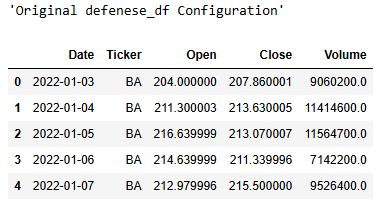, 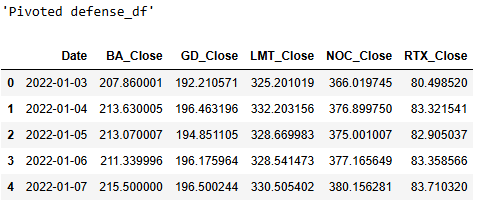

In [16]:
# First we need to reorganize and pivot the defense_df from back in lesson 1 to accomodate the inputs of this function
# Feel free to uncomment the display columns to display the tables above in the output

#display('Original defenese_df Configuration',defense_df.head())

new_def_df = pd.DataFrame(defense_df, columns={'Date','Ticker','Close'})

pivoted_df = new_def_df.pivot_table(index='Date', columns='Ticker', values='Close')
pivoted_df.columns = [f'{col}_Close' for col in pivoted_df.columns]
pivoted_df = pivoted_df.reset_index()
#display('Pivoted defense_df',pivoted_df.head())

tickers = ['BA','GD', 'LMT', 'NOC', 'RTX']
transition_matrices = {}

for ticker in tickers:
    transition_matrices[ticker] = get_transition_matrix(pivoted_df[f'{ticker}_Close'])

# View side by side
for company, matrix in transition_matrices.items():
    print(f"\nTransition Matrix for {company}")
    print(matrix)


Transition Matrix for BA
          U         S         D
U  0.510373  0.095436  0.394191
S  0.431373  0.117647  0.450980
D  0.458937  0.111111  0.429952

Transition Matrix for GD
          U         S         D
U  0.434599  0.147679  0.417722
S  0.514286  0.128571  0.357143
D  0.510417  0.135417  0.354167

Transition Matrix for LMT
          U         S         D
U  0.404545  0.154545  0.440909
S  0.561644  0.095890  0.342466
D  0.436893  0.155340  0.407767

Transition Matrix for NOC
          U         S         D
U  0.422727  0.136364  0.440909
S  0.463768  0.115942  0.420290
D  0.452381  0.147619  0.400000

Transition Matrix for RTX
          U         S         D
U  0.440909  0.136364  0.422727
S  0.484848  0.151515  0.363636
D  0.422535  0.126761  0.450704


If that view doesn't do much for you, here is a more visual appealing display of the matrices.

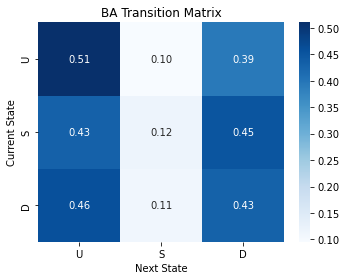

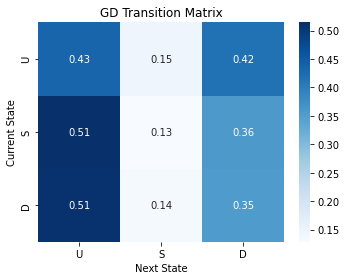

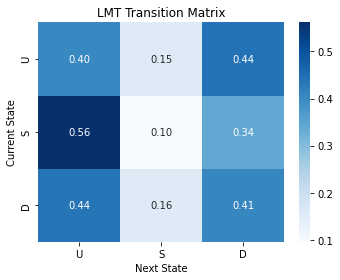

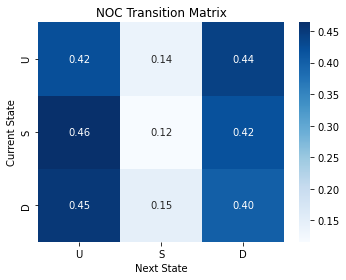

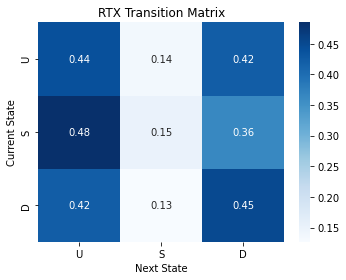

In [17]:
import seaborn as sea

def plot_transition_heatmap(matrix, company):
    plt.figure(figsize=(5, 4))
    sea.heatmap(matrix, annot=True, cmap="Blues", fmt=".2f", cbar=True)
    plt.title(f"{company} Transition Matrix")
    plt.xlabel("Next State")
    plt.ylabel("Current State")
    plt.tight_layout()
    plt.show()

# Plot for all 5 companies
for ticker in tickers:
    plot_transition_heatmap(transition_matrices[ticker], ticker)


A higher probability of staying in the same state suggests a **momentum-driven** stock, where price trends are more likely to continue. On the other hand, a lower probability indicates **mean-reverting behavior**, where price movements are more likely to reverse. This can offer useful insights for both long-term investors and short-term traders looking to manage expectations and risk. Generally, if the Momentum Tendency is > 0.70 it means it has momentum and is likely to stay in its current state. Anything < 0.55 means that the stock frequently changes state and is likely more volatile.


In [18]:
momentum_scores = {}

for ticker, matrix in transition_matrices.items():
    # Sum of diagonal (staying in the same state)
    same_state_prob = matrix.loc['U', 'U'] + matrix.loc['S', 'S'] + matrix.loc['D', 'D']
    momentum_scores[ticker] = same_state_prob

# Sort by strongest "momentum"
momentum_sorted = sorted(momentum_scores.items(), key=lambda x: x[1], reverse=True)

print("Stocks Ranked by Momentum Tendency (Higher = More Likely to Stay in Same State):")
for ticker, score in momentum_sorted:
    print(f"{ticker}: {score:.2f}")

Stocks Ranked by Momentum Tendency (Higher = More Likely to Stay in Same State):
BA: 1.06
RTX: 1.04
NOC: 0.94
GD: 0.92
LMT: 0.91


As you can see, the values for each stock are well above the threshold, meaning they’re more likely to stay in their current state rather than switch frequently between up and down. This suggests that these stocks don’t experience extreme day-to-day volatility and tend to move in a more consistent pattern over time.

That kind of behavior can make investing in these companies feel more stable. While it doesn’t guarantee which direction the stock will go, it can give investors more confidence that they’re looking at a potentially steady or “value”-oriented stock. For option traders, this may help reduce the anxiety of sudden, unexpected price swings—whether hoping for gains or trying to manage downside risk.


Another way to measure the Volatility and Predictability is by use and calculation of **Entropy**. It is commonly referred to as being a measure of uncertainty or randomness in a system. Thus, in our case, it can help us to determine how predictable a stocks next state is based on its current one. This pretty much leads you to the golden question of: How confident am I in what is going to happen next? The idea of maximizing that confidence is something for a later date. See the Entropy calculation below and the function, calculate_entropy.

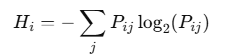

In [19]:
def calculate_entropy(matrix):
    entropy = 0
    for i in matrix.index:
        row = matrix.loc[i]
        for prob in row:
            if prob > 0:
                entropy += -prob * np.log2(prob)
    return entropy

entropy_scores = {ticker: calculate_entropy(matrix) for ticker, matrix in transition_matrices.items()}
entropy_sorted = sorted(entropy_scores.items(), key=lambda x: x[1], reverse=True)

print("\nStocks Ranked by Transition Entropy (Higher = More Unpredictable):")
for ticker, entropy in entropy_sorted:
    print(f"{ticker}: {entropy:.2f} bits")


Stocks Ranked by Transition Entropy (Higher = More Unpredictable):
RTX: 4.31 bits
NOC: 4.29 bits
GD: 4.28 bits
LMT: 4.25 bits
BA: 4.14 bits


Before we discuss the results, it is important to mention that a low entropy score means that the stock is more predictable and is likely suitable for long-term investments. However, if there is a high entropy score, it means that the movements are more random. Thus, you'd likely have better luck signing up for apple bobbing at the local fair and pulling out a Rolex than you would betting on a stock with an extremely high entropy score. Not actually, but its still not a great idea.

The Entropy scores for the stocks above are actually quite high, and higher than expected. The maximum entropy score is produced when all probabilities across each row are split evenly, and in this case, 1/3. That would produce an entropy score of 4.755 bits. On the other end, the minimum entropy score is 0 and is found when the probability of one state is 1 and the others are 0. This means that there is no variability, and hence, zero entropy. 

Why are our values seemingly high? That is entirely driven by the epsilon value, or threshold, that is set to define each states boundaries. The smaller the epsilon value, the finer the analysis targets movements. Thus, an epsilon value of 0.002 is found to be quite low and is representative of a value that would be used for short-term trading strategies where the goal is to make large sums of money off of small movements. That technique is often used by so-called "scalpers" in the market.


### 💃 The Last Dance: Simulating Stock Movement with Markov Chains

Based on the same transition matrices that we've been using for the past few calculations, we can simulate the price direction/movement and reconstruct a price series for Lockheed Martin over the next year. For that we must assume that there are constant percentage returns for each state. ie. Stable = 0% return, U/D = +/- 0.5%. See the plot below that depicts the final simulation results.

In [20]:
def simulate_markov_path(matrix, start_state='S', n_steps=30):
    states = ['U', 'S', 'D']
    current_state = start_state
    state_sequence = [current_state]

    for _ in range(n_steps):
        probs = matrix.loc[current_state].values
        next_state = np.random.choice(states, p=probs)
        state_sequence.append(next_state)
        current_state = next_state

    return state_sequence

In [21]:
def generate_price_path(state_sequence, start_price=485.94, up=0.005, down=-0.005, stable=0):
    price_path = [start_price]

    for state in state_sequence[1:]:
        last_price = price_path[-1]
        if state == 'U':
            new_price = last_price * (1 + up)
        elif state == 'D':
            new_price = last_price * (1 + down)
        else:
            new_price = last_price * (1 + stable)
        price_path.append(new_price)

    return price_path

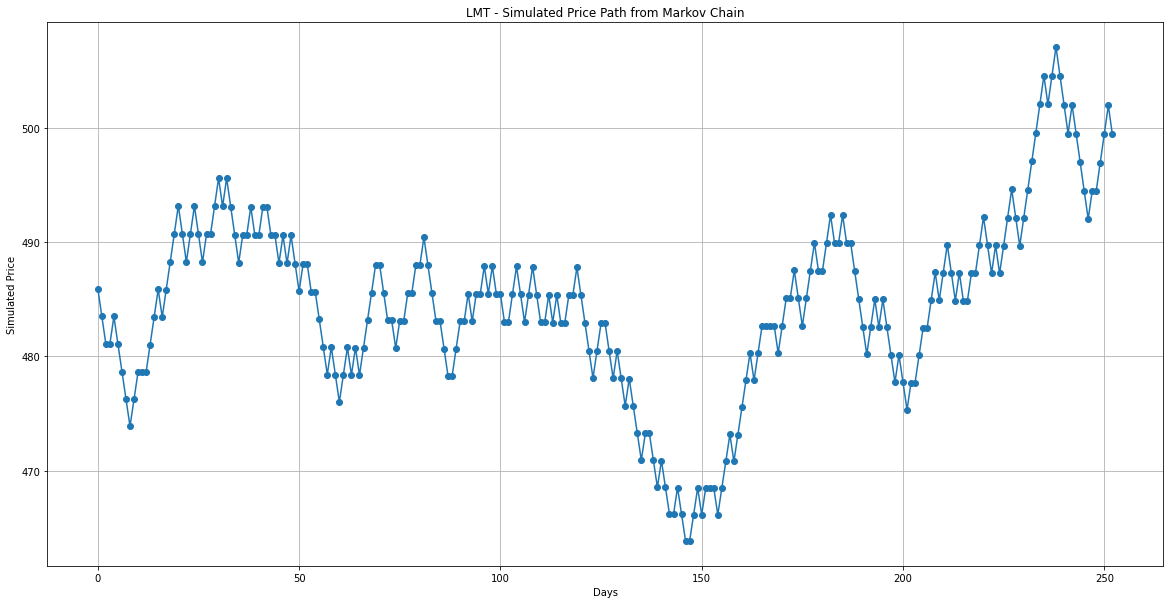

In [22]:
ticker = 'LMT'  
start_state = 'S'
n_steps = 252

state_seq = simulate_markov_path(transition_matrices[ticker], start_state, n_steps)
price_sim = generate_price_path(state_seq, start_price=485.94)

# Plot it
plt.figure(figsize=(20, 10))
plt.plot(price_sim, marker='o', linestyle='-')
plt.title(f"{ticker} - Simulated Price Path from Markov Chain")
plt.xlabel("Days")
plt.ylabel("Simulated Price")
plt.grid(True)
plt.show()

### ⛓️‍💥 Conclusion to Markov Chain Analysis ⛓️‍💥

**Markov Chain analysis** provided a surprisingly insightful way to examine stock behavior. By simplifying daily price movements into states like Up, Down, and Stable, it allows analysts to uncover patterns in how likely a stock is to continue in its current direction or reverse course. This makes it possible to analyze momentum, mean-reversion tendencies, and the overall “noise” (randomness) level of each stock. Simulating future price paths based on these transitions added an extra layer of perspective on how a stock might behave under similar conditions.

That said, Markov Chains aren’t psychic. The method assumes the next move depends only on the current state—not the full history—so it completely ignores things like earnings reports, breaking news, or market sentiment. It also doesn’t factor in how big a price move is—just the category it falls into. And by reducing continuous returns into discrete states, a fair amount of detail is inevitably lost.

Still, as a starting point for understanding randomness and short-term behavioral patterns in stocks, Markov Chains are a solid tool. With more complexity—like using Hidden Markov Models or regime-switching frameworks—this type of analysis could become even more powerful. But even in its basic form, it gave valuable insight into how different stocks behave, and how predictable (or not) they really are.

## ✏️ Back to the Drawing Board!

Diving into the world of Quants, it proves to be an extremely eye-opening and curiosity-sparking topic. What started as a simple exploration of how stock prices move turned into a deeper journey through stochastic modeling, option pricing, risk simulation, and probabilistic forecasting.

Through techniques like Geometric Brownian Motion, Monte Carlo simulations, and the Black-Scholes model, the notebook explored how randomness and risk can be quantified—and even turned into tools for decision-making. Then, by stepping into Markov Chain analysis, the project shifted gears from modeling raw prices to modeling behavioral patterns, showing how stocks transition between momentum and mean-reversion in surprisingly measurable ways.

Of course, none of these models are perfect. Markets are messy, companies surprise us, and the future refuses to sit quietly inside a clean equation. But these tools provide a framework—a mathematical lens—that helps make sense of uncertainty. More importantly, they form the foundation of the kind of thinking that drives quantitative finance: structured, data-driven, and always curious.

This project was just a starting point. There’s plenty more to explore—from volatility surfaces to machine learning models, or integrating macroeconomic indicators into these frameworks. But if nothing else, it confirmed one thing: quants don’t predict the future—they build the best possible map of the unknown using math, logic, and a bit of luck.